## Set up

## Load Dataset

In [2]:
import pandas as pd
data = pd.read_csv(r'../resources/processed_data.csv')

In [3]:
print(data.head())
data.shape

                                    Processed_Review sentiment
0  one review mention watch oz episod hook right ...  positive
1  wonder littl product film techniqu unassum old...  positive
2  thought wonder way spend time hot summer weeke...  positive
3  basic famili littl boy jake think zombi closet...  negative
4  petter mattei love time money visual stun film...  positive


(49582, 2)

### TFIDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Chuyển dữ liệu sang đặc trưng số sử dụng TF-IDF
tfidf = TfidfVectorizer(max_features=10000) 

# Chia data thành các tập train và test
X = tfidf.fit_transform(data['Processed_Review']).toarray()
# Chuyển sentiment positive thành 1 và negative thành 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape

(34707, 10000)

## Multi-layer Perceptron

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Hàm tạo mô hình MLP
def create_mlp_model(input_dim, num_layers=1, num_neurons=128):
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    for _ in range(num_layers - 1):  
        model.add(Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrapper cho mô hình Keras
class KerasMLPWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, num_layers=1, num_neurons=128, batch_size=128, epochs=15):
        self.input_dim = input_dim
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        self.model = create_mlp_model(self.input_dim, self.num_layers, self.num_neurons)
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
        self.history = self.model.fit(
            X, y, 
            batch_size=self.batch_size, 
            epochs=self.epochs, 
            validation_split=0.2, 
            callbacks=[early_stopping],
            verbose=1
        )
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  

# Cài đặt GridSearchCV với wrapper Keras
grid_params = {
    'num_layers': [1, 3, 5],  
    'num_neurons': [128, 256]  
}

# Chạy GridSearch trên tập train
model = KerasMLPWrapper(input_dim=X_train.shape[1])
grid_search = GridSearchCV(estimator=model, param_grid=grid_params, cv=3, n_jobs=1, verbose=1)
grid_search_result = grid_search.fit(X_train, y_train)

# In kết quả tốt nhất
print(f"Best parameters: {grid_search_result.best_params_}")


Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7992 - loss: 0.5577 - val_accuracy: 0.8187 - val_loss: 0.7356
Epoch 2/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9430 - loss: 0.2905 - val_accuracy: 0.8695 - val_loss: 0.6322
Epoch 3/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9667 - loss: 0.2334 - val_accuracy: 0.8647 - val_loss: 0.5097
Epoch 4/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9760 - loss: 0.2107 - val_accuracy: 0.8632 - val_loss: 0.4680
Epoch 5/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9797 - loss: 0.2062 - val_accuracy: 0.8580 - val_loss: 0.5180
Epoch 6/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9818 - loss: 0.2066 - val_accuracy: 0.8615 - val_loss: 0.5595
Epoch 7/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9853 - loss: 0.1977 - val_accuracy: 0.8619 - val_loss: 0.5803
Epoch 7: early stopping
Epoch 1/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8104 -

465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      7461
           1       0.86      0.89      0.87      7414

    accuracy                           0.87     14875
   macro avg       0.87      0.87      0.87     14875
weighted avg       0.87      0.87      0.87     14875

Test Accuracy: 0.8723


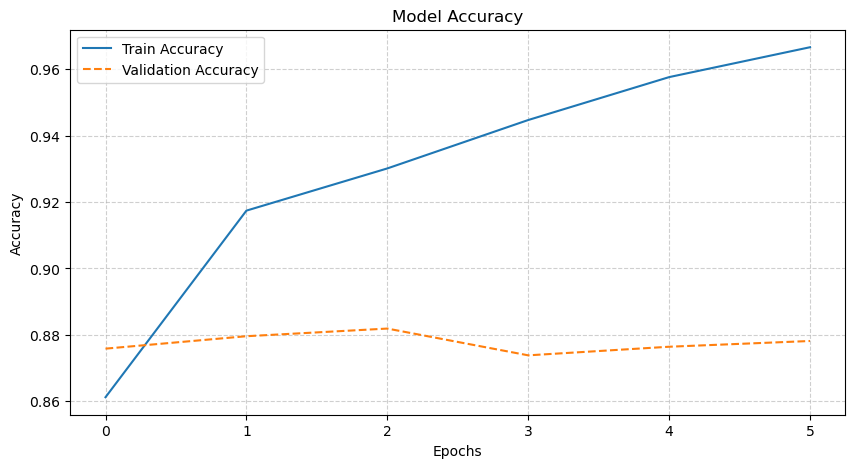

<Figure size 800x600 with 0 Axes>

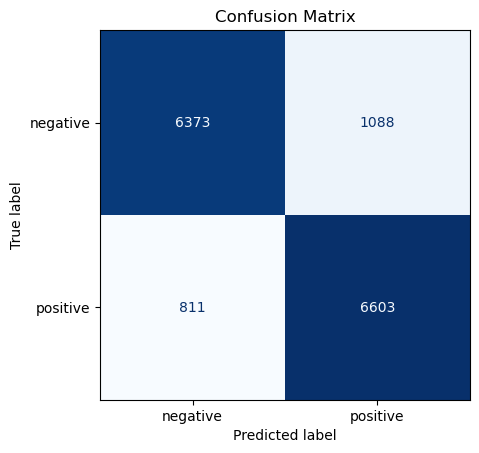

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Đánh giá mô hình tốt nhất trên tập test
best_model = grid_search_result.best_estimator_
y_pred = best_model.predict(X_test)

# Báo cáo phân loại và độ chính xác
print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Vẽ Biểu Đồ Độ Chính Xác
history = best_model.history

# Biểu đồ Độ Chính Xác
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()  # Hiển thị biểu đồ độ chính xác

# Vẽ Ma Trận Nhầm Lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix')
plt.show()  # Hiển thị ma trận nhầm lẫn


### Word2Vec

- MLP

In [115]:
import pickle 
with open("../resources/X_w2v_train.pkl", "rb") as f:
    X_w2v_train = pickle.load(f)
with open("../resources/X_w2v_test.pkl", "rb") as f:
    X_w2v_test = pickle.load(f)
with open("../resources/y_train.pkl", "rb") as f:
    y_w2v_train = pickle.load(f)
with open("../resources/y_test.pkl", "rb") as f:
    y_w2v_test = pickle.load(f)

In [116]:
y_w2v_train.shape

(35000,)

In [117]:
print(y_w2v_train[:5])

38094    negative
40624    positive
49425    negative
35734    positive
41708    negative
Name: sentiment, dtype: object


In [118]:
import numpy as np

X_w2v_train = np.array(X_w2v_train)
X_w2v_test = np.array(X_w2v_test)

X_w2v_train.shape

(35000, 400)

In [119]:
import numpy as np

y_w2v_train = [1 if label == 'positive' else 0 for label in y_w2v_train]
y_w2v_test = [1 if label == 'positive' else 0 for label in y_w2v_test]

y_w2v_train = np.array(y_w2v_train)
y_w2v_test = np.array(y_w2v_test)


In [123]:
print(y_w2v_test)

[1 1 0 ... 0 1 1]


In [131]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Hàm tạo mô hình MLP
def create_mlp_model(input_dim, num_layers=1, num_neurons=128):
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    for _ in range(num_layers - 1):  
        model.add(Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrapper cho mô hình Keras
class KerasMLPWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, num_layers=1, num_neurons=128, batch_size=128, epochs=20):
        self.input_dim = input_dim
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        self.model = create_mlp_model(self.input_dim, self.num_layers, self.num_neurons)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
        self.history = self.model.fit(
            X, y, 
            batch_size=self.batch_size, 
            epochs=self.epochs, 
            validation_split=0.2, 
            callbacks=[early_stopping],
            verbose=1
        )
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  

# Cài đặt GridSearchCV với wrapper Keras
grid_params = {
    'num_layers': [1, 3, 5],  
    'num_neurons': [128, 256]  
}

# Chạy GridSearch trên tập train
model = KerasMLPWrapper(input_dim=X_w2v_train.shape[1])
grid_search = GridSearchCV(estimator=model, param_grid=grid_params, cv=3, n_jobs=1, verbose=1)
grid_search_result = grid_search.fit(X_w2v_train, y_w2v_train)

# In kết quả tốt nhất
print(f"Best parameters: {grid_search_result.best_params_}")


Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8180 - loss: 0.5516 - val_accuracy: 0.8346 - val_loss: 0.6593
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8809 - loss: 0.3941 - val_accuracy: 0.8762 - val_loss: 0.5160
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8885 - loss: 0.3587 - val_accuracy: 0.8815 - val_loss: 0.4092
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8836 - loss: 0.3436 - val_accuracy: 0.8815 - val_loss: 0.3437
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8849 - loss: 0.3306 - val_accuracy: 0.8804 - val_loss: 0.3198
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8885 - loss: 0.3160 - val_accuracy: 0.8894 - val_loss: 0.3018
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8861 - loss: 0.3101 - val_accuracy: 0.8830 - val_loss: 0.3131
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8862 - loss: 0.3079 - val_accuracy: 0.

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      7411
           1       0.89      0.89      0.89      7589

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Test Accuracy: 0.8902


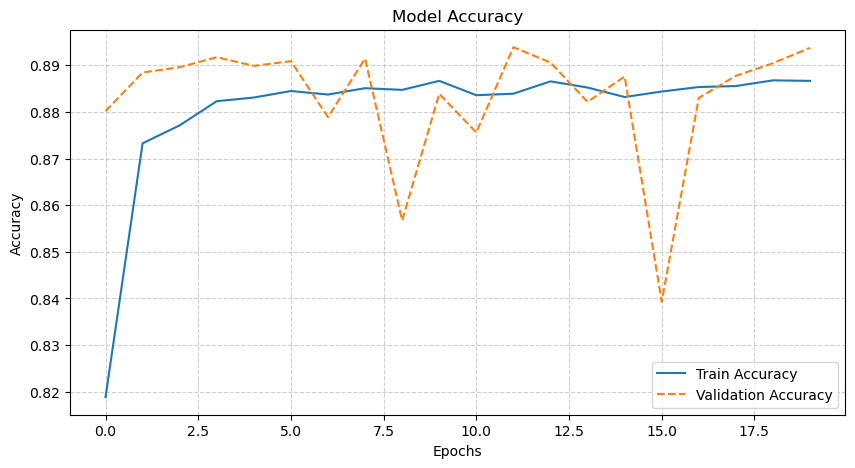

<Figure size 800x600 with 0 Axes>

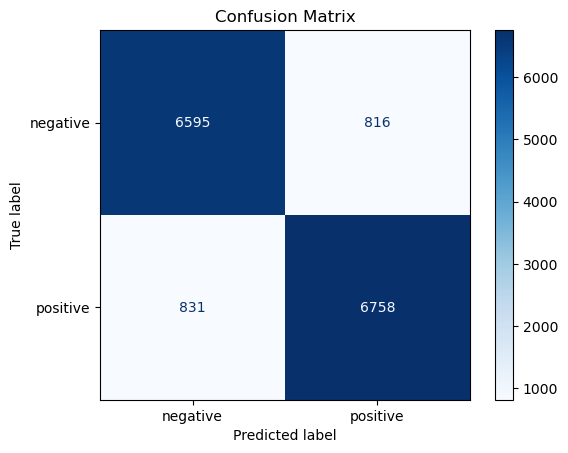

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Đánh giá mô hình tốt nhất trên tập test
best_model = grid_search_result.best_estimator_
y_w2v_pred = best_model.predict(X_w2v_test)

# Báo cáo phân loại và độ chính xác
print("Classification Report:")
print(classification_report(y_w2v_test, y_w2v_pred))

accuracy = accuracy_score(y_w2v_test, y_w2v_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Vẽ Biểu Đồ Độ Chính Xác
history = best_model.history

# Biểu đồ Độ Chính Xác
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()  # Hiển thị biểu đồ độ chính xác


# Vẽ Ma Trận Nhầm Lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_w2v_test, y_w2v_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot(cmap='Blues', colorbar=True)
plt.title('Confusion Matrix')
plt.show()


- Bidirectional Long-short term memory (BiLSTM)

### GloVe

- Bidirectional Long Short-Term Memory Network 

In [29]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv(r'../resources/processed_data.csv')

In [30]:
X2 = []
sentences = list(data['Processed_Review'])
for sen in sentences:
    X2.append(sen)
    
# chuyển đổi sentiment thành dạng số
label_encoder = LabelEncoder()
y2 = label_encoder.fit_transform(data['sentiment'])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)


In [31]:
import numpy as np

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, BatchNormalization
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences

In [32]:
# Lớp embedding của keras cho phép chúng ta chuyển đổi các từ thành các vector số
# Phương thức fit_on_text sẽ tạo ra một từ điển từ các từ trong tập dữ liệu
# Phương thức texts_to_sequences sẽ chuyển đổi các câu thành các chuỗi số

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train2)

X_train2 = word_tokenizer.texts_to_sequences(X_train2)
X_test2 = word_tokenizer.texts_to_sequences(X_test2)

In [33]:
import io
import json

# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('../resources/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [34]:
# Thêm 1 để lưu trữ kích thước cho các từ mà không có embedding từ trước

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

60410

In [35]:
# Để đảm bảo rằng tất cả các câu có cùng độ dài, chúng ta sẽ sử dụng phương thức pad_sequences của keras để thêm các giá trị 0 vào các câu ngắn hơn

maxlen = 200

X_train2 = pad_sequences(X_train2, padding='post', maxlen=maxlen)
X_test2 = pad_sequences(X_test2, padding='post', maxlen=maxlen)

In [36]:
# Sử dụng các vector từ GloVe để tạo ra một ma trận embedding cho các từ trong tập dữ liệu

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('../resources/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [37]:
# Tạo ma trận embedding có 100 cột 
# Chứa các vector 100 chiều của GloVe cho tất cả các từ trong tập dữ liệu

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix.shape

(60410, 100)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, LayerNormalization

# Redesigned BiLSTM Model
BiLSTM = Sequential([
    Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    
     # First BiLSTM Layer
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),  
    
    # Second BiLSTM Layer
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),  
    
    # Conv1D Layer
    Conv1D(100, 5, activation='relu'),
    
    # GlobalMaxPooling1D Layer
    GlobalMaxPooling1D(),
    # Dense Layers
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.3),                  # Dropout for regularization
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the Model
BiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BiLSTM.summary()

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     6,041,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,041,000 (23.04 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,041,000 (23.04 MB)

In [45]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

BiLSTM_history = BiLSTM.fit(X_train2, y_train2,
                            batch_size=128,
                            epochs=15,
                            verbose=1,
                            validation_split=0.2,
                            callbacks=[early_stopping])

Epoch 1/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.6349 - loss: 0.6278 - val_accuracy: 0.7737 - val_loss: 0.4874
Epoch 2/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.7405 - loss: 0.5243 - val_accuracy: 0.7872 - val_loss: 0.4482
Epoch 3/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.7727 - loss: 0.4762 - val_accuracy: 0.8054 - val_loss: 0.4199
Epoch 4/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.7974 - loss: 0.4448 - val_accuracy: 0.8299 - val_loss: 0.3775
Epoch 5/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.8062 - loss: 0.4236 - val_accuracy: 0.8414 - val_loss: 0.3669
Epoch 6/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.8195 - loss: 0.3973 - val_accuracy: 0.8450 - val_loss: 0.3529
Epoch 7/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.8333 - loss: 0.3757 - val_accuracy: 0.8390 - val_loss: 0.3681
Epoch 8/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.8395 - loss: 0.3629 - val_accu

In [46]:
from sklearn.preprocessing import LabelEncoder

# Evaluate on test data
test_loss, test_accuracy = BiLSTM.evaluate(X_test2, y_test2, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification report
# Classification report
y_pred2 = (BiLSTM.predict(X_test2) > 0.5).astype("int32").flatten()

print(classification_report(y_test2, y_pred2, target_names=label_encoder.classes_))


465/465 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.8618 - loss: 0.3199
Test Loss: 0.3208, Test Accuracy: 0.8614
465/465 ━━━━━━━━━━━━━━━━━━━━ 45s 95ms/step
              precision    recall  f1-score   support

    negative       0.88      0.84      0.86      7404
    positive       0.85      0.88      0.86      7471

    accuracy                           0.86     14875
   macro avg       0.86      0.86      0.86     14875
weighted avg       0.86      0.86      0.86     14875



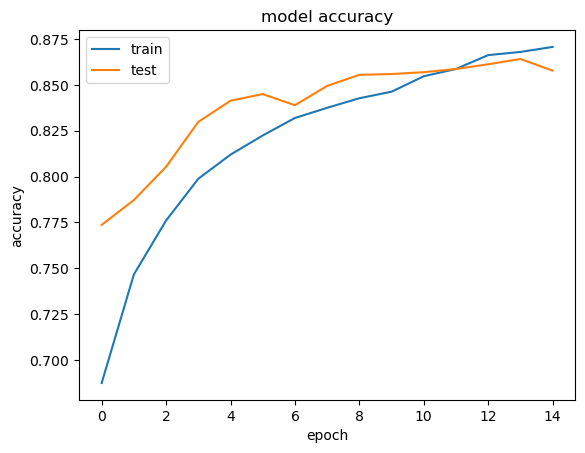

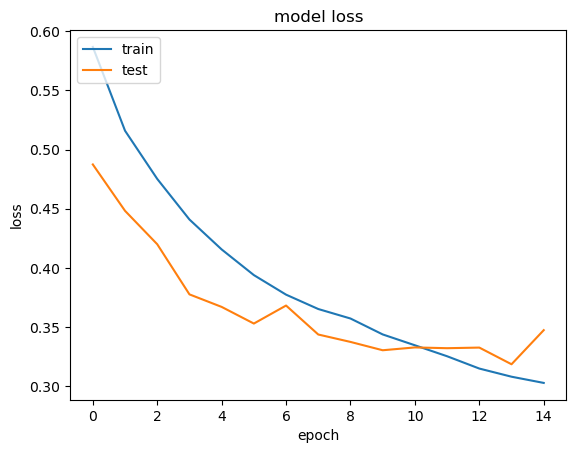

In [47]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(BiLSTM_history.history['accuracy'])
plt.plot(BiLSTM_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(BiLSTM_history.history['loss'])
plt.plot(BiLSTM_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

y_test shape: (14875,)
y_pred shape: (14875,)


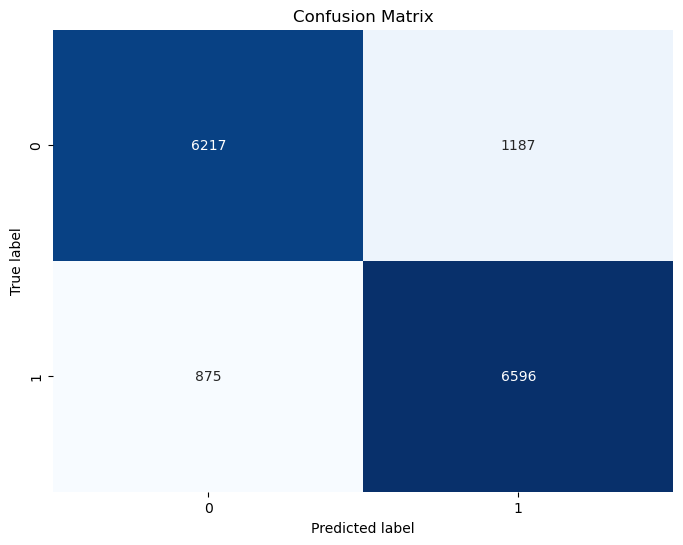

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Kiểm tra kích thước
print("y_test shape:", y_test2.shape)
print("y_pred shape:", y_pred2.shape)

# Tính toán Confusion Matrix
cf_matrix = confusion_matrix(y_test2, y_pred2)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

- Multi-Layer Perceptron

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization,Flatten
from keras.optimizers import Adam

# Define the MLP model
MLP = Sequential([
    Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=True),
    Flatten(),
    Dense(128, activation='relu', input_dim=input_dim),  # Input layer
    BatchNormalization(),  # Batch normalization
    Dropout(0.4),          # Dropout for regularization

    #Dense(64, activation='relu'),  # Hidden layer
    #BatchNormalization(),          # Batch normalization
    #Dropout(0.4),                  # Dropout for regularization

    Dense(1, activation='sigmoid')  # Output layer (2 classes) [0] and [1], not one-hot encoding
])

# Compile the model
MLP.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(MLP.summary())

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     6,041,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,041,000 (23.04 MB)

 Trainable params: 6,041,000 (23.04 MB)

 Non-trainable params: 0 (0.00 B)

None


In [36]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

MLP_history = MLP.fit(X_train2, y_train2,
                            batch_size=128,
                            epochs=10,
                            verbose=1,
                            validation_split=0.2,
                            callbacks=[early_stopping])

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.6387 - loss: 0.7057 - val_accuracy: 0.7789 - val_loss: 0.4693
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.8812 - loss: 0.2953 - val_accuracy: 0.8227 - val_loss: 0.4093
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.9518 - loss: 0.1398 - val_accuracy: 0.8271 - val_loss: 0.4750
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.9820 - loss: 0.0596 - val_accuracy: 0.8235 - val_loss: 0.5665
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.9948 - loss: 0.0241 - val_accuracy: 0.8254 - val_loss: 0.6691
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.9983 - loss: 0.0103 - val_accuracy: 0.8279 - val_loss: 0.7345
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.9994 - loss: 0.0057 - val_accuracy: 0.8264 - val_loss: 0.7354


In [37]:
from sklearn.preprocessing import LabelEncoder

# Evaluate on test data
test_loss, test_accuracy = MLP.evaluate(X_test2, y_test2, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification report
# Classification report
y_pred2 = (BiLSTM.predict(X_test2) > 0.5).astype("int32").flatten()

print(classification_report(y_test2, y_pred2, target_names=label_encoder.classes_))


465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8222 - loss: 0.4162
Test Loss: 0.4092, Test Accuracy: 0.8251
465/465 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step
              precision    recall  f1-score   support

    negative       0.78      0.78      0.78      7404
    positive       0.78      0.78      0.78      7471

    accuracy                           0.78     14875
   macro avg       0.78      0.78      0.78     14875
weighted avg       0.78      0.78      0.78     14875



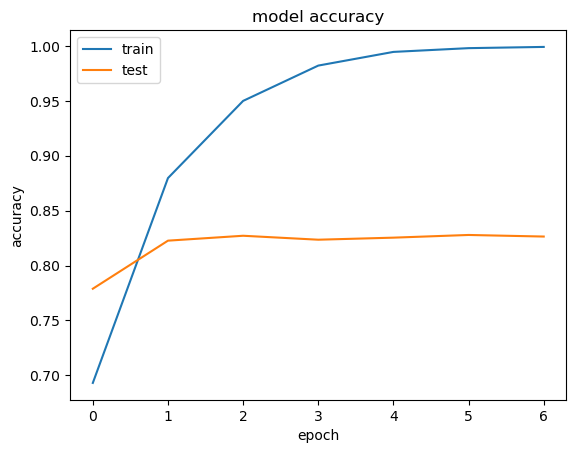

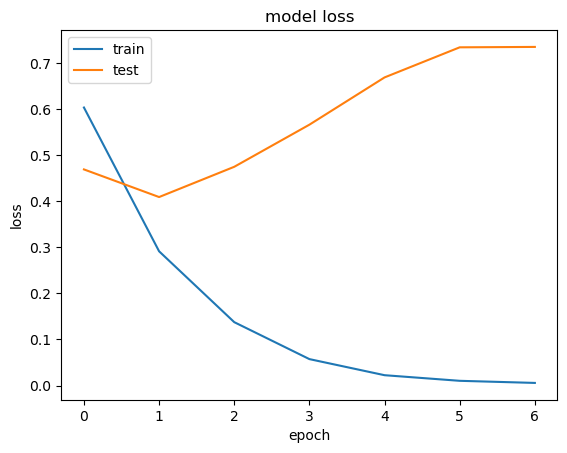

In [38]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(MLP_history.history['accuracy'])
plt.plot(MLP_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(MLP_history.history['loss'])
plt.plot(MLP_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

y_test shape: (14875,)
y_pred shape: (14875,)


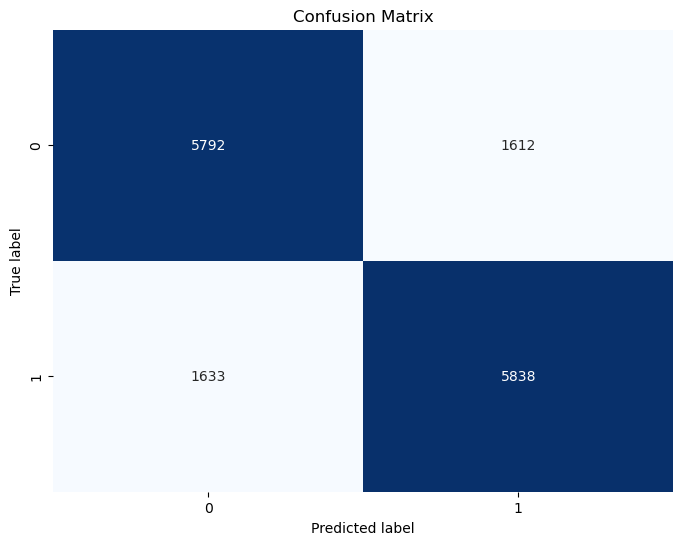

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Kiểm tra kích thước
print("y_test shape:", y_test2.shape)
print("y_pred shape:", y_pred2.shape)

# Tính toán Confusion Matrix
cf_matrix = confusion_matrix(y_test2, y_pred2)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()